## Workshop notebooks

When working on your solution, you can save your notebook as many times as you like. You can also submit 
as many times as you like. In fact, it is a good idea to save and submit often.

**Only the last submission before the deadline** will be marked.
Note that you have to **submit** at least once for your work to be marked.

The notebook contains cells with code. Some of the code is (intentionally) missing. Please insert appropriate code where it says 'YOUR CODE HERE' and delete or comment out the 'raise NotImplementedError()' statements. Cells which do not contain any 'YOUR CODE HERE' lines will allow you to test your code; if they return an error there is something wrong with your implementation; if they do not return an error your code might be correct (it is unfortunately not possible to check for every possible error).

## Workshop IV: Chaos

This workshop looks at chaotic systems and analyses them in terms of Poincare sections.

The Euler-Cromer and the equation for the non-linear pendulum are taken from the previous workshop

Total marks for this assignment is 10.

We use the same notation as in the previous workshop: the coordinates of a pendulum are the angle measured from the vertical ($\theta$ in the notes, $\phi$ in this notebook), and its time derivative ($\omega={\rm d}\phi/{\rm d}t$). In the implementation below, $\phi$ and $\omega$ are the first and second entry of the state vector $x$:

` x=np.array([phi, omega]) `

The first few cells are identical to the previous notebook, to make sure that the integrator you've developed gives the right answer.


In [15]:
%matplotlib inline
import numpy as np
import pylab
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd())
from DEq_Solver import DEq_Solver
import solvers  # this file implements the solvers from previous problem Harmonic Motion workshop

 
  We will use the `Pendulum` class as a kernel for the normal Euler and Runge-Kutta method and the new Euler-Cromer method. We will implement `dx_dt(self,x,t)` for the former and `dx_dt_EC(self,x,t)` for the latter. You have access to


    x        - the state vector
    t        - the time
    self.delta_t  - the time step
    
    self.L        - pendulum's length
    self.g        - gravity acceleration
    self.FD       - driving acceleration
    self.OD       - driving frequency
    self.q        - friction coefficient
    self.nolin    - whether pendulum is linear (small angle approximation)
    
You can copy your answers from the previous workshop    


In [16]:
# You may want to copy your solution from the previous workshop
class Pendulum:
    def __init__(self, L, q=0, F_D=0, Omega_D=0, nonlinear=False):
        """Initialize a pendulum object with 
        length L [m], 
        friction coefficient q [], 
        driving acceleration amplitude F_D [N/kg],
        frequency Omega_D [s^-1]. 
        and a switch to enable the nonlinear pendulum"""
        self.L = float(L)
        self.q = float(q)
        self.FD = float(F_D)
        self.OD = float(Omega_D)
        self.nonlin = nonlinear
        self.g = 9.81

    def dx_dt(self,x,t):
        # implement the derivative here! It should include drag and driving forces and 
        # treat both linear or non-linear cases. It should return dx/dt as an array.
        # YOUR CODE HERE
        dx = []
        dx.append(x[1])
        if self.nonlin:
            dx.append(-1 * (self.g / self.L) * np.sin(x[0]) - self.q * x[1] + self.FD * np.sin(self.OD * t))
        else:
            dx.append(-1 * (self.g / self.L) * x[0] - self.q * x[1] + self.FD * np.sin(self.OD * t))
        return np.array(dx)
       

In [17]:
# this tests the dx_dt implementation
testPend=Pendulum(2.3,1.1,0.5,2.2,False)
testPendNL=Pendulum(2.3,1.1,0.5,2.2,True)
assert np.isclose(testPendNL.dx_dt([0.5,0.3],0.7),[ 0.3, -1.87509123]).all()
assert np.isclose(testPend.dx_dt([0.5,0.3],0.7),[ 0.3, -1.96284578]).all()

In [18]:
'''The EulerCromerSolver class, derived from the DEq_Solver class. This way you also 
have access to all public variables and methods as defined in DEq_Solver'''
class EulerCromerSolver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        # this should implement the EC step, as before you have access to
        # self.x, self.t , self.delta_t and the derivative as self.kernel.dx_dt_EC
        # YOUR CODE HERE
        dx = self.dx_dt_EC(self.x, self.t)
        self.x[0] += dx[0] * self.delta_t
        self.x[1] += dx[1] * self.delta_t
        self.t += self.delta_t
        
    def dx_dt_EC(self,x,t):
        tmp = self.kernel.dx_dt(x, t)[1]
        dx = []
        dx.append(x[1] + tmp * self.delta_t)
        dx.append(tmp)
        return np.array(dx)

In [19]:
# this tests the EC step
testEC=EulerCromerSolver(testPend)
testEC.x=[0.3,0.2]
testEC.t=0
testEC.delta_t=0.01
testEC.makeStep()
assert np.isclose(testEC.t,0.01)
assert np.isclose(testEC.x,[ 0.30185004,  0.18500435]).all()

## Evolution of the non-linear driven pendulum

Below we compute the evolution of the non-linear pendulum. Use the following parameters (length `L`, friction coefficient `q`, driving frequency `Omega_D`, initial time `t0`, final time `t1`, all in SI units)

` - L = 9.81, q = 0.5, Omega_D = 2./3.`

` - t0 = 0, t1 = 150`

` - nonlinear = True`

Compute the evolution for two values of the driving acceleration $F_D$, taking $F_D=0.5$ and $F_D=1.2$.

For each of these, calculate the evolution from $\phi_0=0.2$, the initial angle in radians,
as well as and $\phi_0=0.2+10^{-3}$, which correspond to a very small difference in initial conditions.
  

Plot phi(t) for these four cases using the cell below. Use different colours and different linestyles to distinguish the curves.
Annotate the axis and provide a legend.

Compare your plot to Evolution.pdf. Convince yourself that your solution looks similar.
I used a timestep of dt=0.04

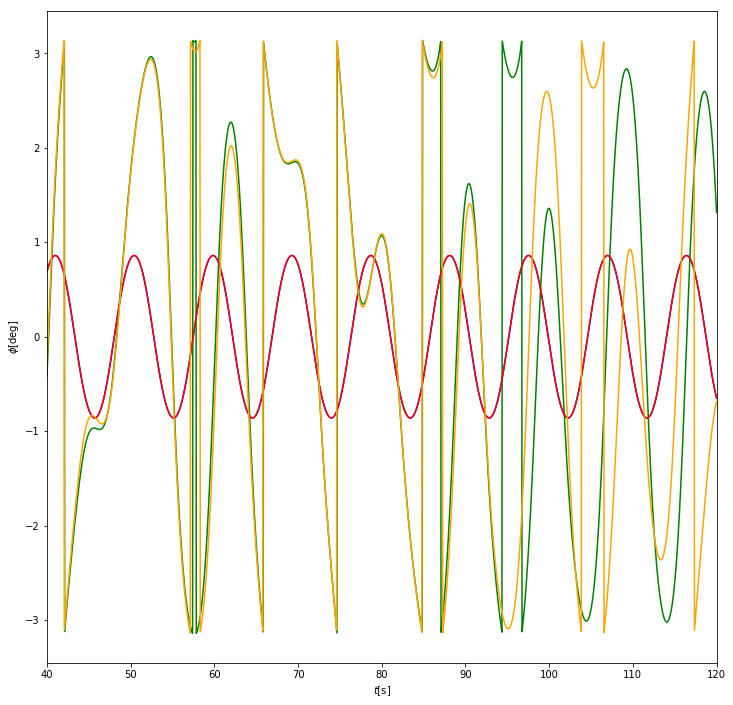

In [20]:
# YOUR CODE HERE
def makePlots(solver,
              dt = 0.04,  # time step size
              t0 = 0,     # start time t1 (s)
              t1 = 150.,   # End time t1 (s)
              phi0 = 0.2,    # initial angle (deg)
              logscale = False # logscale for energy plot
             ):
    colors = ['b','g','r','orange']
    colors_index = 0
    fig, ax = plt.subplots(1, 1,figsize = (12, 12))
    for phi in phi0:
        for sol in solver:
            x0 = np.array([phi, 0])
            result = sol.solve(x0, t0, t1, dt)
            ts = sol.timeSteps()
            coords = sol.coordinateSteps()
            rads, omegas = coords
            for i in range (len(rads)):
                while rads[i] > np.pi:
                    rads[i] = rads[i] - 2 * np.pi
                while rads[i] < -np.pi:
                    rads[i] = rads[i] + 2 * np.pi
            ax.plot(ts, rads, c=colors[colors_index])
            colors_index += 1
            ax.set_xlim(40, 120)
            ax.set_ylabel(r'$\phi [\mathrm{deg}]$')
            ax.set_xlabel(r'$t [\mathrm{s}]$')
            
F_Ds = [0.5, 1.2]

sol = []
for F in F_Ds:
    pend = Pendulum(L = 9.81, q = 0.5, Omega_D = 2./3., nonlinear = True, F_D = F)
    ECsolver = EulerCromerSolver(pend)
    sol.append(ECsolver)
phis = [0.2, 0.201]
makePlots(solver=sol,t1=150,phi0=phis)

## Lyapunov exponents

When the pendulum is not chaotic, the evolution of two identical pendulums that start from slightly different initial angles phi0, remains close, meaning

$|\Delta \phi(t)|=|\phi_1(t)-\phi_2(t)|$

remains small. This is the case for $F_D=0.5$. In contrast when the pendulum is chaotic, $|\Delta \phi(t)|$ increases rapidly with $t$, until it saturates.

Plot $\log_{10}|\Delta \phi(t)|$ versus time for the two cases discussed before, $F_D=0.5$ and $F_D=1.2$.
Use the plot labeling in the cell below.

**2 marks**



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


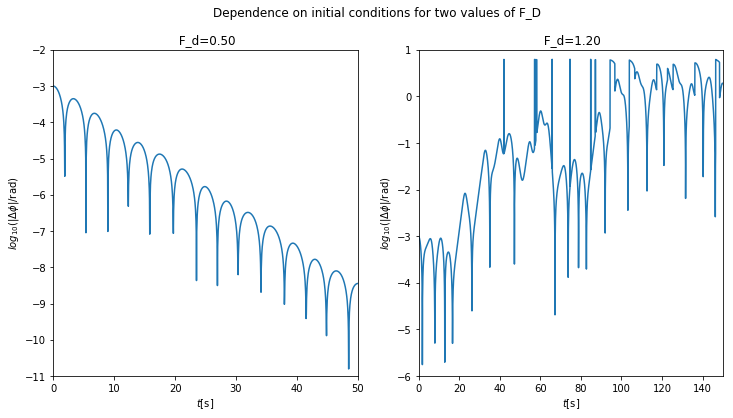

In [21]:
# plot how quickly the difference in angle diverges for two choices of F_D
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle('Dependence on initial conditions for two values of F_D')

# Case of low driving amplitude             
ax[0].set_title(' F_d=%.2f'%F_Ds[0])
ax[0].set_ylabel(r'$log_{10}(|\Delta\phi| / \mathrm{rad})$')
ax[0].set_xlabel(r'$t [\mathrm{s}]$')
ax[0].set_xlim(0,50)
ax[0].set_ylim(-11,-2)
# YOUR CODE HERE
dt = 0.04  # time step size
t0 = 0.    # start time t1 (s)
t1 = 150.   # End time t1 (s)
phi0 = [0.2, 0.2 + 1e-3]
degrees = []
for phi in phi0:
    x0 = np.array([phi, 0])
    result = sol[0].solve(x0, t0, t1, dt)
    ts = sol[0].timeSteps()
    coords = sol[0].coordinateSteps()
    rads, omegas = coords
    for i in range (len(rads)):
        while rads[i] > np.pi:
            rads[i] = rads[i] - 2 * np.pi
        while rads[i] < -np.pi:
            rads[i] = rads[i] + 2 * np.pi
    degrees.append(rads)
ans = abs(degrees[0] - degrees[1])
ax[0].plot(ts, np.log10(ans))

# Case of high driving amplitude    
ax[1].set_title(' F_d=%.2f'%F_Ds[1])
ax[1].set_ylabel(r'$log_{10}(|\Delta\phi| / \mathrm{rad})$')
ax[1].set_xlabel(r'$t [\mathrm{s}]$')
ax[1].set_xlim(0,150)
ax[1].set_ylim(-6,1)
phi0 = [0.2, 0.2 + 1e-3]
degrees = []
for phi in phi0:
    x0 = np.array([phi, 0])
    result = sol[1].solve(x0, t0, t1, dt)
    ts = sol[1].timeSteps()
    coords = sol[1].coordinateSteps()
    rads, omegas = coords 
    for i in range (len(rads)):
        while rads[i] > np.pi:
            rads[i] = rads[i] - 2 * np.pi
        while rads[i] < -np.pi:
            rads[i] = rads[i] + 2 * np.pi
    degrees.append(rads)
ans = abs(degrees[0] - degrees[1])
ax[1].plot(ts, np.log10(ans))
plt.savefig('Figure1.pdf')    

For the two values of F_D, F_D=0.5, and F_D=1.2, plot the phase-space diagram.
Use the plot labelling in the cell below.

**2 marks**

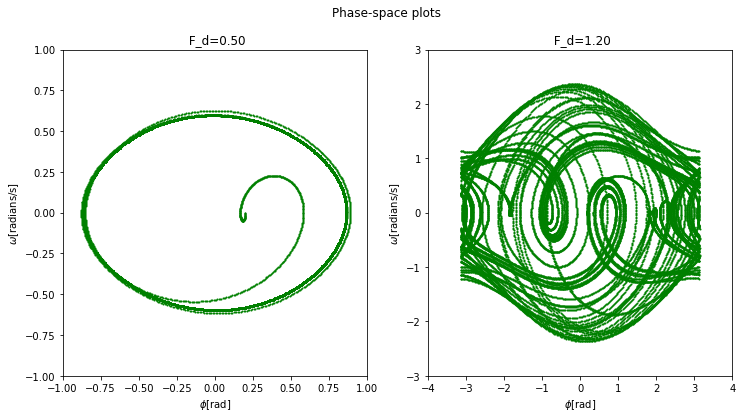

In [63]:
# Make phase-space diagram
F_Ds        = [0.5,1.2]     # For these two values of driving amplitude
t0          = 0
t1          = 400
dt          = np.pi / (2./3.) / 300 # Set time-step as a fraction of the period

# run pendulums for the two values of F_D in the array F_Ds

# Make plots
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle('Phase-space plots' )

# Small driving             
ax[0].set_title(' F_d=%.2f'%F_Ds[0])
ax[0].set_xlabel(r'$\phi [\mathrm{rad}]$')
ax[0].set_ylabel(r'$\omega [\mathrm{radians/s}]$')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)

ax[1].set_title(' F_d=%.2f'%F_Ds[1])
ax[1].set_xlabel(r'$\phi [\mathrm{rad}]$')
ax[1].set_ylabel(r'$\omega [\mathrm{radians/s}]$')
ax[1].set_xlim(-4,4)
ax[1].set_ylim(-3,3)

solvers = []
phi = 0.2
history = []
# YOUR CODE HERE
for F_D in F_Ds:
    pend = Pendulum(L = 9.81, q = 0.5, Omega_D = 2./3., nonlinear = True, F_D = F_D)
    ECsolver = EulerCromerSolver(pend)
    solvers.append(ECsolver)

index = 0
phi_arrays = []
omega_arrays = []
for sol in solvers:
    phi_array = []
    omega_array = []
    x0 = np.array([phi, 0])
    result = sol.solve(x0, t0, t1, dt)
    ts = sol.timeSteps()
    coords = sol.coordinateSteps()
    rads, omegas = coords
    for i in range (len(rads)):
        while rads[i] > np.pi:
            rads[i] = rads[i] - 2 * np.pi
        while rads[i] < -np.pi:
            rads[i] = rads[i] + 2 * np.pi
    for i in range(len(ts)):
        if np.isclose(np.sin(2./3 * ts[i]), 0):
            phi_array.append(rads[i])
            omega_array.append(omegas[i])
    phi_arrays.append(phi_array)
    omega_arrays.append(omega_array)
    ax[index].scatter(rads, omegas, c='g', s=1)
    index += 1


# YOUR CODE HERE
plt.savefig('Figure2.pdf')   

Extract from the phase-diagram those points for which $\Omega_D t$ is $2N\pi$, where $N$ is an integer.
Use this subset to make a Poincare section.
Use the plot labelling in the cell below.

**2 marks**

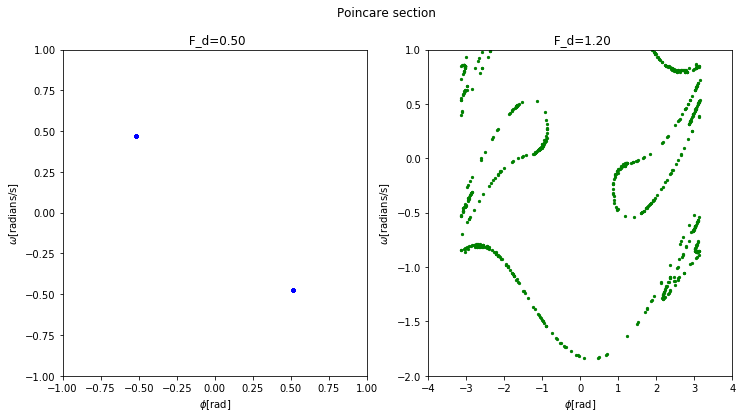

In [62]:
# Extract Poincar\'e section
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle('Poincare section' )

# Small driving
ax[0].set_title(' F_d=%.2f'%F_Ds[0])
ax[0].set_xlabel(r'$\phi [\mathrm{rad}]$')
ax[0].set_ylabel(r'$\omega [\mathrm{radians/s}]$')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[1].set_title(' F_d=%.2f'%F_Ds[1])
ax[1].set_xlabel(r'$\phi [\mathrm{rad}]$')
ax[1].set_ylabel(r'$\omega [\mathrm{radians/s}]$')
ax[1].set_xlim(-4,4)
ax[1].set_ylim(-2,1)

# select those times, where sin(Omega_D t) = 0


ax[0].scatter(phi_arrays[0][20:], omega_arrays[0][20:], c='b', s = 5)

        
# Large driving
ax[1].scatter(phi_arrays[1][20:], omega_arrays[1][20:], c='g', s = 5)

plt.savefig('Figure3.pdf')  

## Make the bifurcation diagram for this pendulum

**4 marks**


In [50]:
# Calculate evolution for the following values of the amplitude of the driving force
FD1        = np.arange(1.35, 1.47 , 0.005)
FD2        = np.arange(1.471, 1.488 , 0.001)
F_Ds       = np.concatenate([FD1, FD2])

# Run the pendulum for each value in F_Ds, from t0 = 0, to t1 = 400 Periods
# Use a timestep equal to the period of the driving force divided by 300
# Plot the bifurcation diagram for from t = 300 Periods, to t=400 Periods
# This calculation may take a minute or two to run.


dt         = 2.0 * np.pi / (2./3. * 300)  # time step
t0         = 0
t1         = 400          # final time
Prec       = 300                  # store results from Pred periods on

solvers = []
phi_array = []
FD_array = []

# YOUR CODE HERE
for F_D in F_Ds:
    pend = Pendulum(L = 9.81, q = 0.5, Omega_D = 2./3., nonlinear = True, F_D = F_D)
    ECsolver = EulerCromerSolver(pend)
    solvers.append(ECsolver)

index = 0
for sol in solvers:
    x0 = np.array([phi, 0])
    result = sol.solve(x0, t0, t1, dt)
    ts = sol.timeSteps()
    coords = sol.coordinateSteps()
    rads, omegas = coords
    for i in range (len(rads)):
        while rads[i] > np.pi:
            rads[i] = rads[i] - 2 * np.pi
        while rads[i] < -np.pi:
            rads[i] = rads[i] + 2 * np.pi
    for i in range(len(ts)):
        if ts[i] > 300 and np.isclose(np.sin(2./3 * ts[i]), 0):
            phi_array.append(rads[i])
            FD_array.append(F_Ds[index])
    index += 1

print(" Calculation finished!")       

 Calculation finished!


Plot your results using the cell below

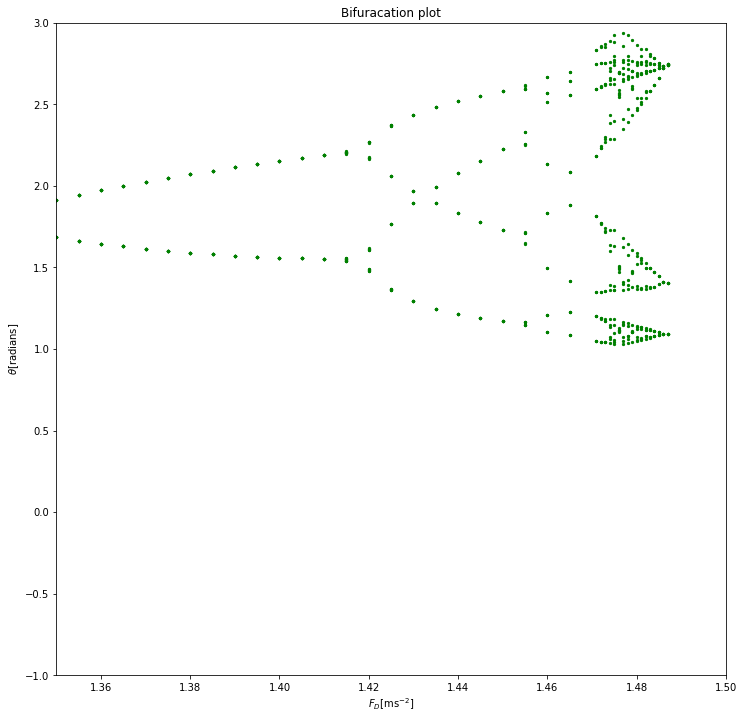

In [51]:
# Bifurcation plot
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.set_title('Bifuracation plot')
ax.set_xlabel(r'$F_D [\mathrm{m s^{-2}}]$')
ax.set_ylabel(r'$\theta [\mathrm{radians}]$')
ax.set_xlim(1.35, 1.5)
ax.set_ylim(-1, 3)

# select those times, where Omega_D t = n 2 pi
        
    
# YOUR CODE HERE
ax.scatter(FD_array, phi_array, c='g', s = 5)

plt.savefig('Figure4.pdf')    

## Playground

Investigate how the bifurcation diagram looks like if you

 - plot $\phi(t)$ when $\sin(\Omega_D t)=0.1$, rather than zero
 
 - plot $\omega$ on the $y$-axis rather than $\phi$

In [ ]:
# Bifurcation plot
# print(soln)

fig, ax = plt.subplots(1, 1, figsize = (12, 12))
fig.suptitle('Poincare section' )

ax.set_title('Bifuracation plot')
ax.set_xlabel(r'$time, t [\mathrm{s}]$')
ax.set_ylabel(r'$\omega [\mathrm{radians/s}]$')
ax.set_xlim(1.35, 1.5)
ax.set_ylim(-2.2, -1.2)

# select those times, where sin(2pi Omega_D t) = 0

for F_D in soln:
    omegas = soln[F_D]["omegas"][300:400:]
    ax.plot(F_D + np.zeros_like(omegas), omegas, '.')
